In [61]:
import os
import sys

import numpy as np
import scipy.io

import sys
sys.path.append("../../dpc/")
from util.point_cloud import point_cloud_distance
from util.simple_dataset import Dataset3D
from util.app_config import config as app_config
from util.tools import partition_range, to_np_object
from util.quaternion import quaternion_rotate
from util.euler import ypr_from_campos

import torch
from torch.utils.tensorboard import SummaryWriter
from models import model_pc_to as model_pc
from util.system import setup_environment
from run.ShapeRecords import ShapeRecords

import pickle
import pdb

In [62]:
def compute_distance(cfg, source_np, target_np):
    """
    compute projection from source to target
    """
    num_parts = cfg.pc_eval_chamfer_num_parts
    partition = partition_range(source_np.shape[0], num_parts)
    min_dist_np = np.zeros((0,))
    idx_np = np.zeros((0,))
    source_pc = torch.from_numpy(source_np).cuda()
    target_pc = torch.from_numpy(target_np).cuda()
    for k in range(num_parts):
        r = partition[k, :]
        src = source_pc[r[0]:r[1]]
        _, min_dist, min_idx = point_cloud_distance(src, target_pc)
        min_dist_0_np = min_dist.cpu().numpy()
        idx_0_np = min_idx.cpu().numpy()
        min_dist_np = np.concatenate((min_dist_np, min_dist_0_np), axis=0)
        idx_np = np.concatenate((idx_np, idx_0_np), axis=0)

    return min_dist_np, idx_np

In [95]:
def get_group(pos,divs):
    scale = divs/2
    yaw, pitch, roll = ypr_from_campos(pos[0], pos[1], pos[2])
    yaw = yaw + np.pi
    # get everything from 0 to 2*pi
    yaw = yaw%(2*np.pi)+0.00000001
    pitch = pitch%(2*np.pi)+0.00000001
    roll = roll%(2*np.pi) + 0.00000001
    
    q1 = np.ceil(scale*yaw/np.pi)-1
    q2 = np.ceil(scale*pitch/np.pi)-1
    q3 = np.ceil(scale*roll/np.pi)-1
    
    return q1*np.square(divs)+q2*divs+q3

def get_yaw_pitch_roll_range(g, divs):
    roll_range = [(g%divs)*2*np.pi/divs , (g%divs+1)*2*np.pi/divs]
    pitch_range = [(int(g/divs)%divs)*2*np.pi/divs, (int(g/divs)%divs+1)*2*np.pi/divs]
    yaw_range = [(int(g/np.square(divs))%divs)*2*np.pi/divs, (int(g/np.square(divs))%divs+1)*2*np.pi/divs]
    
    return yaw_range, pitch_range, roll_range

    

In [94]:
int(220/10)%10

2

In [64]:
    cfg = app_config

    setup_environment(cfg)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dir = cfg.checkpoint_dir

    split_name = "eval"
    dataset_folder = cfg.inp_dir
    
    dataset = ShapeRecords(dataset_folder, cfg, 'test')
    dataset_loader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=cfg.batch_size, shuffle=cfg.shuffle_dataset,
                                                 num_workers=4, drop_last=True)
    
    

Initialized dataset test with size 1355


In [81]:
    divs = 8
    cfg = app_config
    exp_dir = cfg.checkpoint_dir
    num_views = cfg.num_views
    eval_unsup = cfg.eval_unsupervised_shape
    dataset_folder = cfg.inp_dir

    gt_dir = os.path.join(cfg.gt_pc_dir, cfg.synth_set)

    save_pred_name = "{}_{}".format(cfg.save_predictions_dir, cfg.eval_split)
    save_dir = os.path.join(exp_dir, cfg.save_predictions_dir)

    if eval_unsup:
        reference_rotation = scipy.io.loadmat("{}/final_reference_rotation.mat".format(exp_dir))["rotation"]

    dataset = ShapeRecords(dataset_folder, cfg, 'test')

    if cfg.models_list:
        model_names = parse_lines(cfg.models_list)
    else:
        model_names = dataset.file_names
    num_models = len(model_names)

    # making groups for samples and views according to 8 groups of yaw, pitch, roll
    all_images = np.zeros((0,128,128,3))
    chamfer_all = np.zeros((0,2))
    groups = []

    for k in range(250):
        sample = dataset.__getitem__(k)

        print("{}/{}".format(k, num_models))
        print(model_names[k])

        gt_filename = "{}/{}.mat".format(gt_dir, model_names[k]).replace('_features.p', '')
        mat_filename = "{}/{}_pc.pkl".format(save_dir, model_names[k])

        if not os.path.isfile(gt_filename) or not os.path.isfile(mat_filename):
            continue

        with open(mat_filename, 'rb') as handle:
            data = pickle.load(handle)
        all_pcs = np.squeeze(data["points"])
        if "num_points" in data:
            all_pcs_nums = np.squeeze(data["num_points"])
            has_number = True
        else:
            has_number = False
        obj = scipy.io.loadmat(gt_filename)
        Vgt = obj["points"]

        for i in range(num_views):
            chamfer_dists_current = np.zeros((2), dtype=np.float64)

            pred = all_pcs[i, :, :]
            if has_number:
                pred = pred[0:all_pcs_nums[i], :]

            if eval_unsup:
                pred = np.expand_dims(pred, 0)
                pred = quaternion_rotate(torch.from_numpy(pred).cuda(),
                                         torch.from_numpy(reference_rotation).cuda()).cpu().numpy()
                pred = np.squeeze(pred)

            pred_to_gt, idx_np = compute_distance(cfg, pred, Vgt)
            gt_to_pred, _ = compute_distance(cfg, Vgt, pred)
            chamfer_dists_current[0] = np.mean(pred_to_gt)
            chamfer_dists_current[1] = np.mean(gt_to_pred)

            is_nan = np.isnan(pred_to_gt)
            assert (not np.any(is_nan))

            campos = sample['cam_pos'][i]
            images = sample['image'][i].transpose(1,2,0)
            g = get_group(campos, divs)
            groups.append(g)

            all_images = np.concatenate((all_images, np.expand_dims(images,0)))
            chamfer_all = np.concatenate((chamfer_all, np.expand_dims(chamfer_dists_current, 0)))
            #print(i, ":", chamfer_dists_current)
    groups = np.array(groups)
        # current_mean = np.mean(chamfer_dists_current, 0)
        # print("total:", current_mean)        

Initialized dataset test with size 1355
0/1355
ef5eb51bbb7141c119fb4103277a6b93_features.p
1/1355
ff5a945aef7a68ffcf9ff3ee543c2925_features.p
2/1355
fcc996c2c8ff394194887ea54f3cfb87_features.p
3/1355
6d199c744b17d85953735b417976bbf5_features.p
4/1355
11040f463a3895019fb4103277a6b93_features.p
5/1355
39031caf2b11a7f665ea3fba7f481d97_features.p
6/1355
2b8c678b99f7b2807ea88ba060407992_features.p
7/1355
7aabc57856fc6659597976c675750537_features.p
8/1355
c5beb566f512bc8d9e989ccbad3213ca_features.p
9/1355
fde8c87a485a33b78fa2f6eb9fb1de7c_features.p
10/1355
8e5568ec663ae1b7e7526b618f37b43f_features.p
11/1355
c0689f191df5cfe1c785f06f424b9d06_features.p
12/1355
490941bf4a532b62492d9da2668ec34c_features.p
13/1355
6b9c3d42724275cf7a5c8cd74a7bc29a_features.p
14/1355
ce387113cca9c0754d33a7fd9c37a7d2_features.p
15/1355
8aa597e8f5498bb0165de6c381540e39_features.p
16/1355
d0782d2afef19adf4733824eae5cd9ae_features.p
17/1355
33774f1314ea9b504b3c42e318f3affc_features.p
18/1355
972d675d3ce3555d492d9da2668

157/1355
e1e7e66978b888703f146f1fbd99cb1a_features.p
158/1355
c3778a3db3d7060bbb40b038e5e0b7f0_features.p
159/1355
6df81788b1cdd1c3ab93f6188b226527_features.p
160/1355
975d6db745442a755634c21965ee6bab_features.p
161/1355
7fa5ce045ee0a286606aad310bc344b7_features.p
162/1355
8e7f354489bf4d9b65684b1827478535_features.p
163/1355
ee4858f78dc33591100e9bd5c4b0af54_features.p
164/1355
fbee8c9e5b8c0c19492d9da2668ec34c_features.p
165/1355
68dc37f167347d73ea46bea76c64cc3d_features.p
166/1355
bdffe559220b8a561b01b8d225cb89ac_features.p
167/1355
6932261b5c17f0de4733824eae5cd9ae_features.p
168/1355
ed40add41826f68ab76e29c9c43bc7aa_features.p
169/1355
f5b08ab02727922b738dd0d3509c7e47_features.p
170/1355
575cb36c87cd4896c5ae524fbf4f75e1_features.p
171/1355
42140baad25c8598baa1a4ff2c45ffc9_features.p
172/1355
28b605f55e21acffaf88fb4321b22872_features.p
173/1355
7252a2c022a1a3b21f285be552b78f9a_features.p
174/1355
a366bbec303662a3ec545e4e9c852271_features.p
175/1355
4b366b7995cd8d7fce4f274577283b16_feat

### Obtain means of every cluster while grouping by Cam Pose

### Visualizing Groups

In [82]:
import matplotlib.pyplot as plt
import random
def display_nn_images(images, n, displ_str=None):
    samples = random.sample(range(0,images.shape[0]), min(n*n,images.shape[0]))
    f, axarr = plt.subplots(n,n)
    sample_idx = 0
    for i in range(n):
        for j in range(n):
            if sample_idx==len(samples):
                break
            axarr[i,j].imshow(images[samples[sample_idx]])
            sample_idx+=1
    plt.show()
    if displ_str is not None:
        print(displ_str)

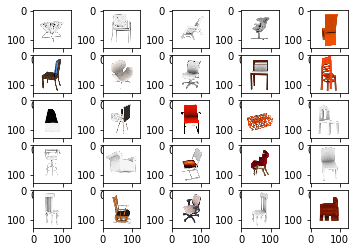

In [83]:
display_nn_images(all_images,5)

### PCA of all images

In [84]:
from sklearn.decomposition import PCA

In [85]:
images_val = all_images.reshape(all_images.shape[0],-1)
pca = PCA(50)
pca_image = pca.fit_transform(images_val)
pca_image = pca_image.reshape(-1,50)
print('Explained variance {}'.format(pca.explained_variance_ratio_.sum()))
all_images_pca = pca_image

Explained variance 0.7362807665355608


In [86]:
from sklearn.cluster import KMeans
n_clusters = 5

In [87]:
kmeans_all = KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(all_images_pca)

In [88]:
kmeans_dict = {}
for k in images_pca_dict:
    kmeans_dict[k] = KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(images_pca_dict[k])

(619, 128, 128, 3)


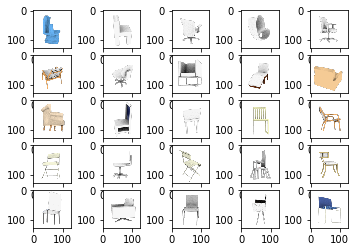

Chamfer Cluster 0: [3.49533177 3.25981727]


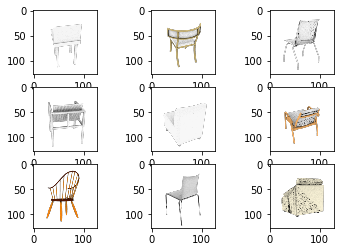

 Chamfer Cluster 0, Group 0.0: [3.76978164 3.38642173], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


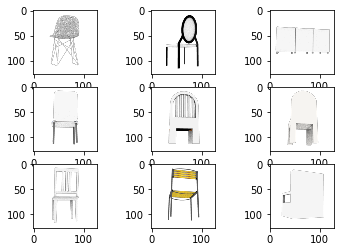

 Chamfer Cluster 0, Group 56.0: [3.46652188 3.47646206], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


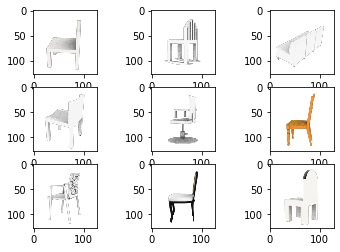

 Chamfer Cluster 0, Group 64.0: [2.9852038  2.90714901], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


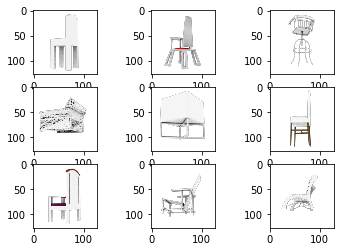

 Chamfer Cluster 0, Group 120.0: [3.24802976 3.13334335], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


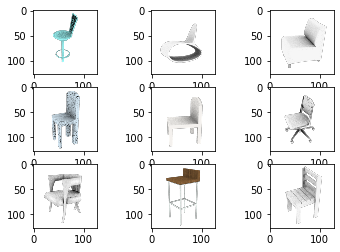

 Chamfer Cluster 0, Group 128.0: [3.84181346 3.46140245], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


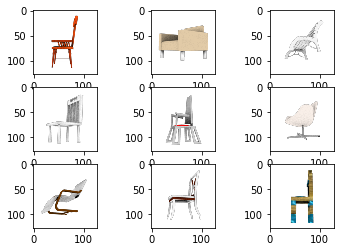

 Chamfer Cluster 0, Group 184.0: [3.15922229 3.65275683], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


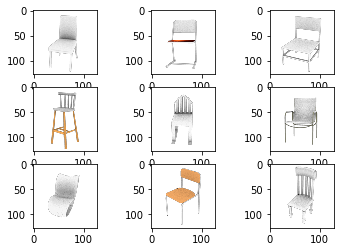

 Chamfer Cluster 0, Group 192.0: [3.0152945 2.8049027], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


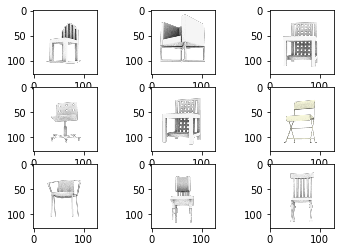

 Chamfer Cluster 0, Group 248.0: [3.61829572 3.65338632], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


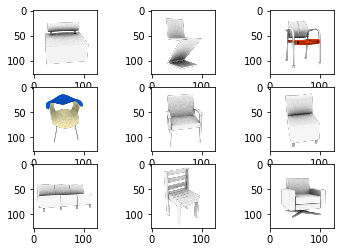

 Chamfer Cluster 0, Group 256.0: [4.00716692 3.8456859 ], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


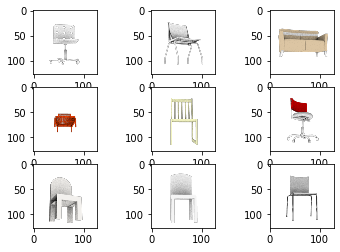

 Chamfer Cluster 0, Group 312.0: [3.62982862 3.33149817], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


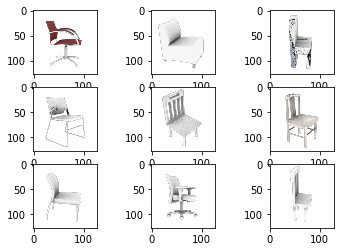

 Chamfer Cluster 0, Group 320.0: [3.78918548 3.07082067], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


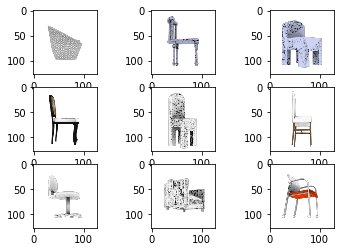

 Chamfer Cluster 0, Group 376.0: [3.50071153 3.31531008], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


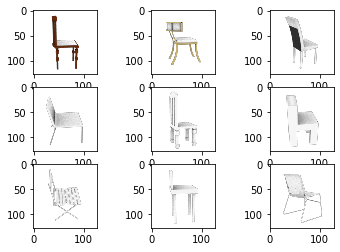

 Chamfer Cluster 0, Group 384.0: [2.98332716 2.85038913], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


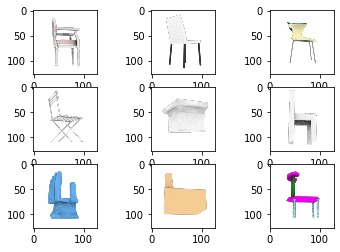

 Chamfer Cluster 0, Group 440.0: [4.28325866 3.62818114], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


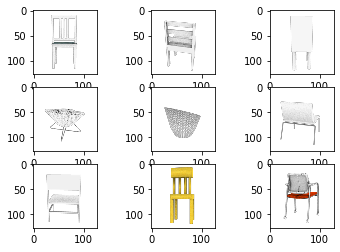

 Chamfer Cluster 0, Group 448.0: [3.48510945 3.25719705], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


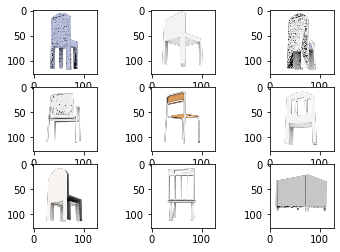

 Chamfer Cluster 0, Group 504.0: [3.20698606 2.90325922], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(75, 128, 128, 3)


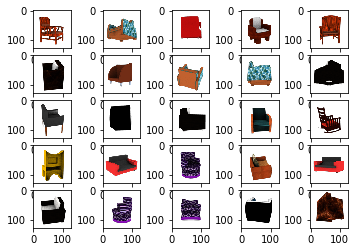

Chamfer Cluster 1: [5.10173965 5.97035044]


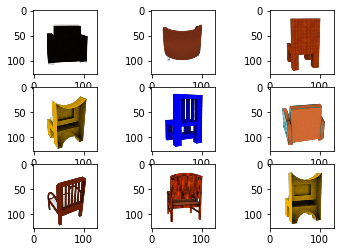

 Chamfer Cluster 1, Group 0.0: [3.97637338 4.15622971], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


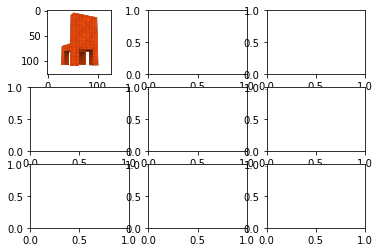

 Chamfer Cluster 1, Group 56.0: [2.88412994 2.22624593], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


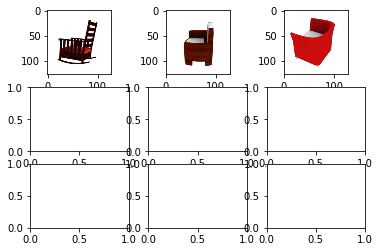

 Chamfer Cluster 1, Group 64.0: [5.96789346 4.60297721], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


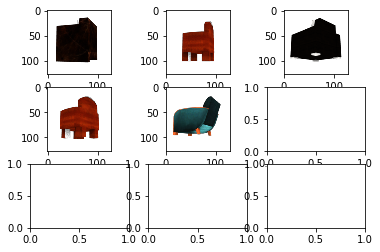

 Chamfer Cluster 1, Group 120.0: [5.08567466 7.18110373], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


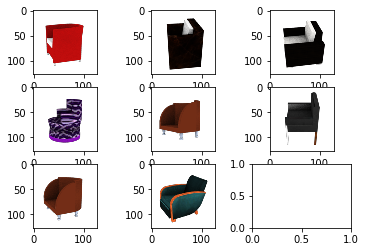

 Chamfer Cluster 1, Group 128.0: [5.31279878 6.06306264], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


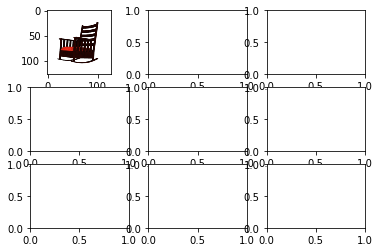

 Chamfer Cluster 1, Group 184.0: [9.69960036 7.23943877], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


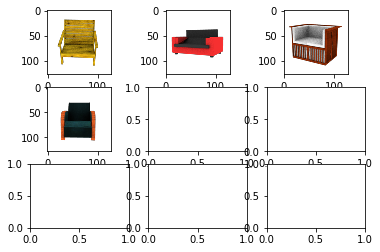

 Chamfer Cluster 1, Group 192.0: [4.92647046 5.93430618], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


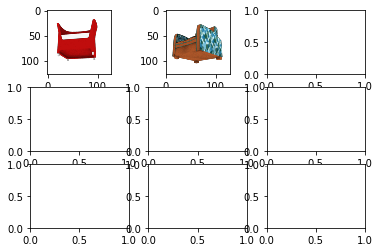

 Chamfer Cluster 1, Group 248.0: [5.71885135 7.49949671], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


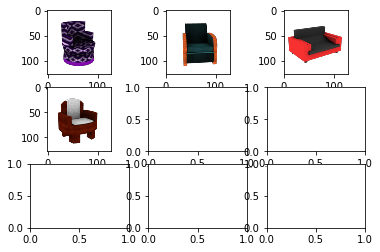

 Chamfer Cluster 1, Group 256.0: [5.78162412 7.18823788], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


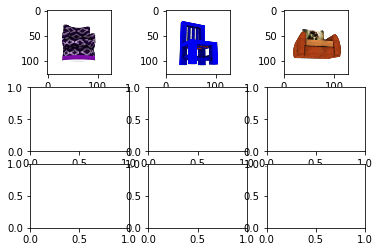

 Chamfer Cluster 1, Group 312.0: [6.67881552 7.11116079], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


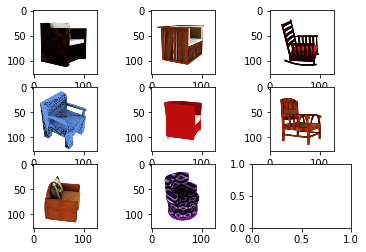

 Chamfer Cluster 1, Group 320.0: [4.6891879  5.15786421], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


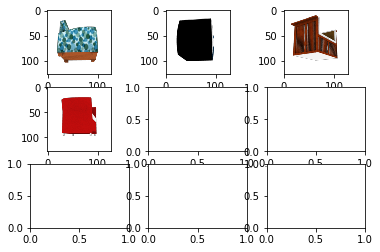

 Chamfer Cluster 1, Group 376.0: [4.3033224  7.03393858], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


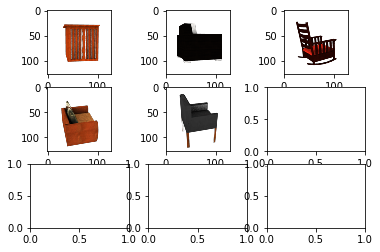

 Chamfer Cluster 1, Group 384.0: [5.42837008 6.86961404], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


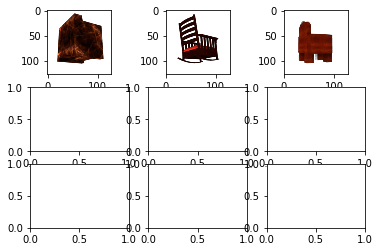

 Chamfer Cluster 1, Group 440.0: [6.61860496 5.66088976], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


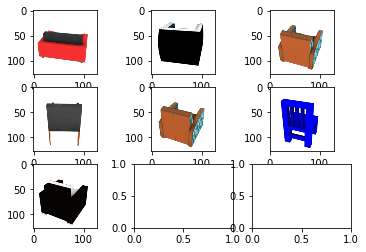

 Chamfer Cluster 1, Group 448.0: [4.43677619 6.56951573], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


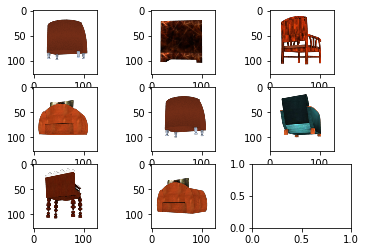

 Chamfer Cluster 1, Group 504.0: [5.16706505 5.89336373], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(186, 128, 128, 3)


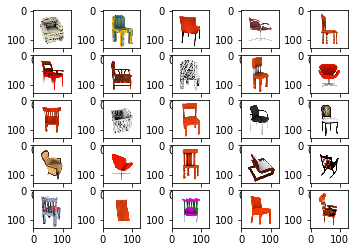

Chamfer Cluster 2: [3.23956624 3.0867791 ]


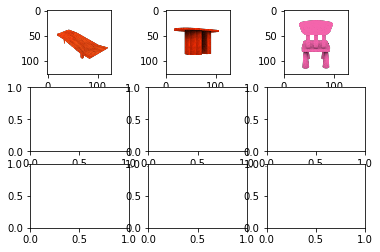

 Chamfer Cluster 2, Group 0.0: [5.93515616 5.44526282], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


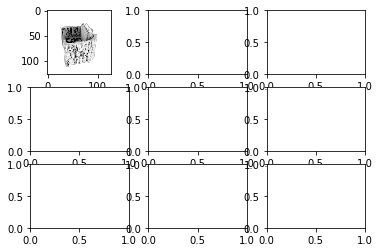

 Chamfer Cluster 2, Group 128.0: [4.78862231 4.25830265], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


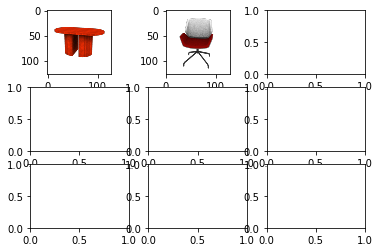

 Chamfer Cluster 2, Group 192.0: [4.15767397 3.71544535], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


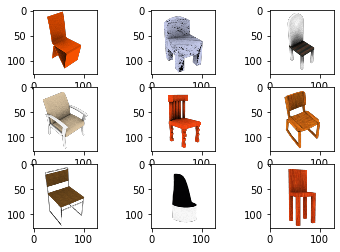

 Chamfer Cluster 2, Group 256.0: [3.12435441 3.07399866], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


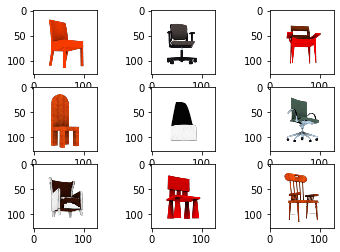

 Chamfer Cluster 2, Group 312.0: [4.05146621 4.03866185], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


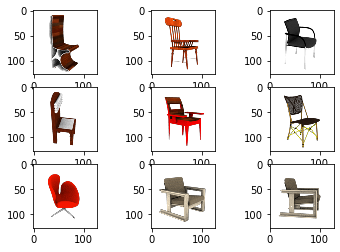

 Chamfer Cluster 2, Group 320.0: [3.3321621  2.90296983], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


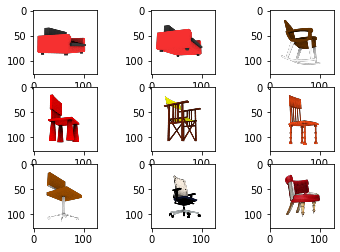

 Chamfer Cluster 2, Group 376.0: [3.8188264  3.97698947], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


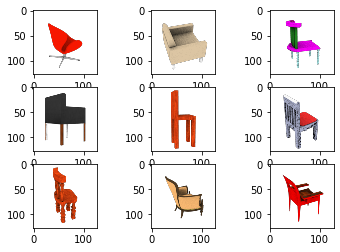

 Chamfer Cluster 2, Group 384.0: [3.1115789  2.96015505], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


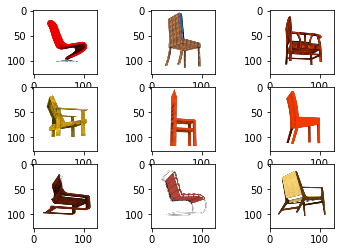

 Chamfer Cluster 2, Group 440.0: [3.2573188  2.79506049], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


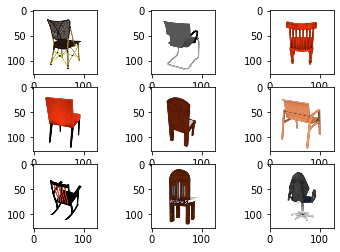

 Chamfer Cluster 2, Group 448.0: [2.49365763 2.51539705], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


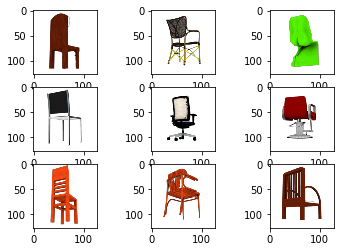

 Chamfer Cluster 2, Group 504.0: [2.82119618 2.50792817], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(206, 128, 128, 3)


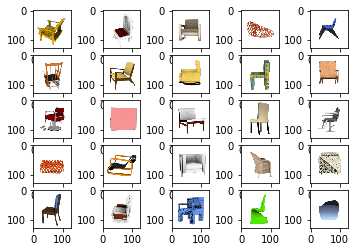

Chamfer Cluster 3: [4.48443739 4.29344431]


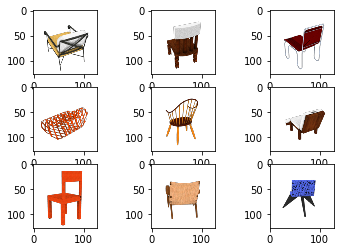

 Chamfer Cluster 3, Group 0.0: [4.19747013 4.27217447], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


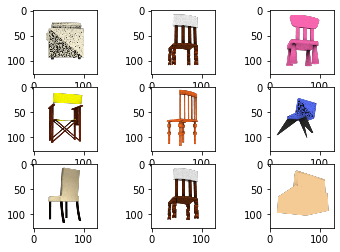

 Chamfer Cluster 3, Group 56.0: [5.16121397 4.47985117], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


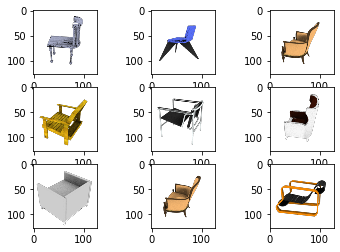

 Chamfer Cluster 3, Group 64.0: [4.55804806 4.10961163], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


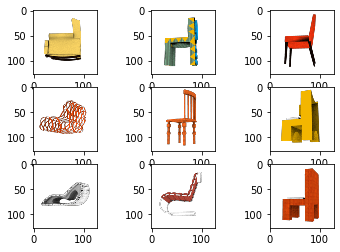

 Chamfer Cluster 3, Group 120.0: [4.83878178 4.59101369], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


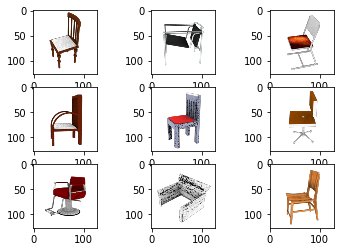

 Chamfer Cluster 3, Group 128.0: [3.34096424 3.08598207], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


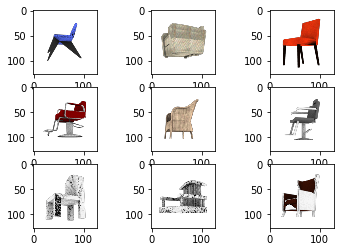

 Chamfer Cluster 3, Group 184.0: [3.73424765 3.26009002], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


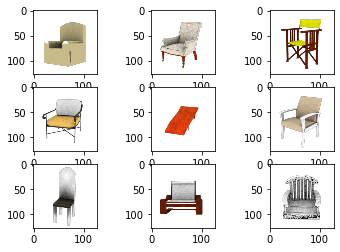

 Chamfer Cluster 3, Group 192.0: [5.19753105 4.82187313], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


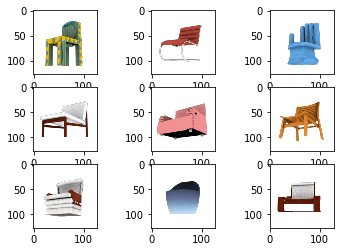

 Chamfer Cluster 3, Group 248.0: [4.44333418 4.30581246], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


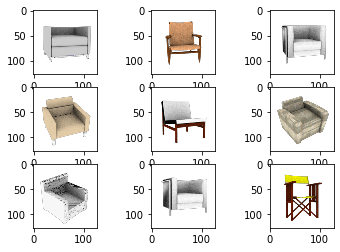

 Chamfer Cluster 3, Group 256.0: [3.53322955 5.54538856], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


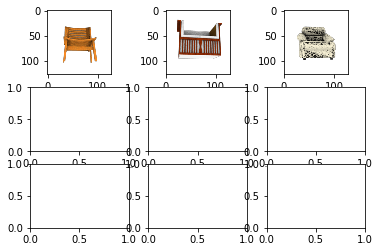

 Chamfer Cluster 3, Group 312.0: [3.92066558 4.84229295], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


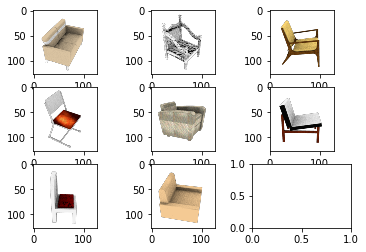

 Chamfer Cluster 3, Group 320.0: [4.58403456 4.91228495], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


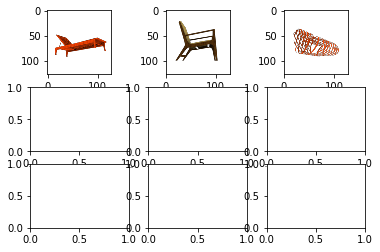

 Chamfer Cluster 3, Group 376.0: [7.67028833 7.03760188], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


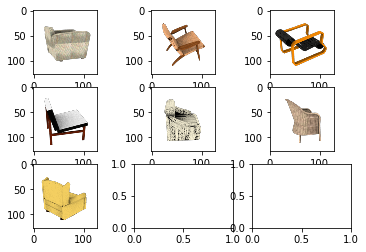

 Chamfer Cluster 3, Group 384.0: [5.48984409 5.14213615], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


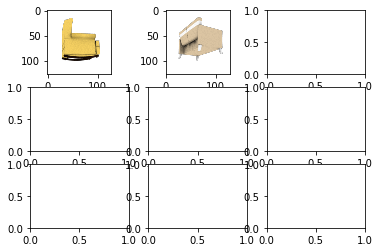

 Chamfer Cluster 3, Group 440.0: [5.78393001 7.09030876], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


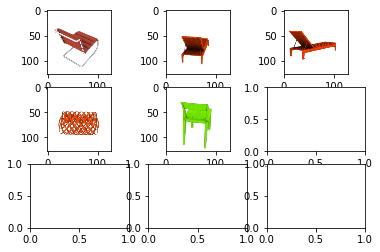

 Chamfer Cluster 3, Group 448.0: [8.75281247 6.11255987], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


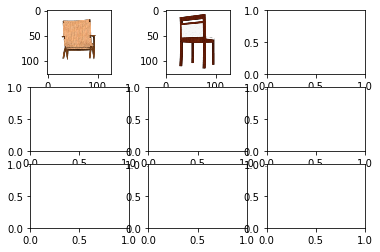

 Chamfer Cluster 3, Group 504.0: [3.33700989 2.42562985], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(159, 128, 128, 3)


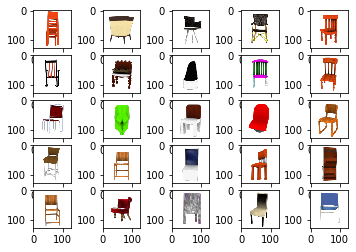

Chamfer Cluster 4: [3.13966488 3.02224496]


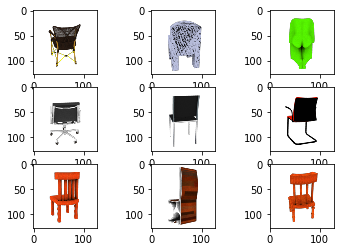

 Chamfer Cluster 4, Group 0.0: [3.70465655 3.4599325 ], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


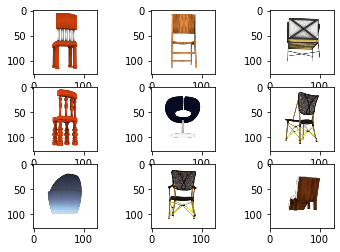

 Chamfer Cluster 4, Group 56.0: [3.86727648 3.20369349], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


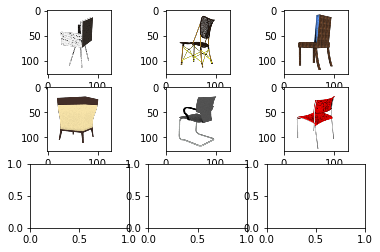

 Chamfer Cluster 4, Group 64.0: [2.75835022 2.17406313], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


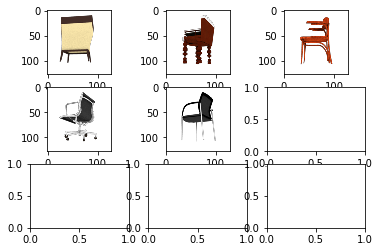

 Chamfer Cluster 4, Group 120.0: [2.24767942 2.43953346], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


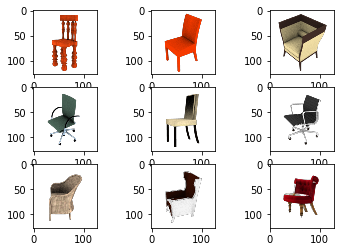

 Chamfer Cluster 4, Group 128.0: [2.75721612 2.5414312 ], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


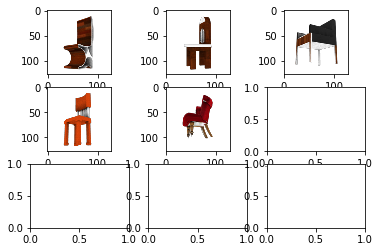

 Chamfer Cluster 4, Group 184.0: [4.02054588 4.17467149], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


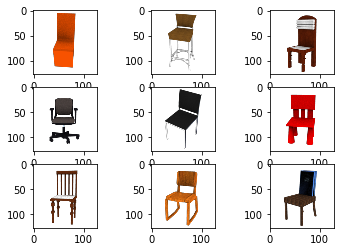

 Chamfer Cluster 4, Group 192.0: [3.02850897 2.82363073], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


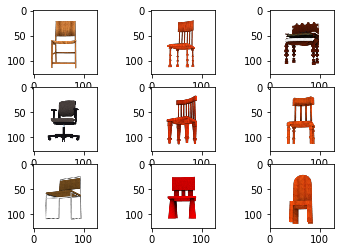

 Chamfer Cluster 4, Group 248.0: [2.17487997 2.38697342], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


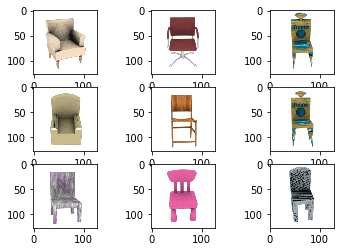

 Chamfer Cluster 4, Group 256.0: [2.91624062 3.04927033], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


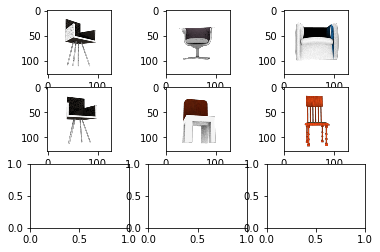

 Chamfer Cluster 4, Group 312.0: [2.43119304 3.07013366], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


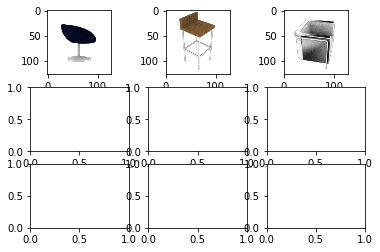

 Chamfer Cluster 4, Group 320.0: [2.53114244 3.21829975], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


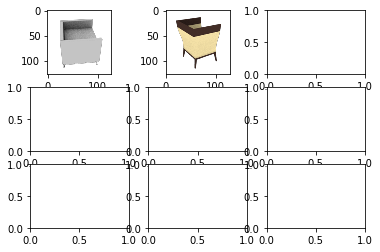

 Chamfer Cluster 4, Group 384.0: [3.91950425 5.02750176], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


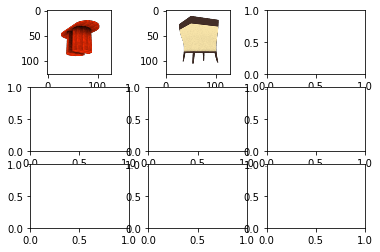

 Chamfer Cluster 4, Group 440.0: [3.96235329 3.0702153 ], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


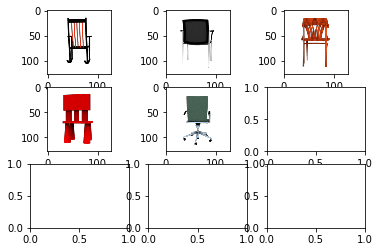

 Chamfer Cluster 4, Group 448.0: [2.1428006  2.76106708], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


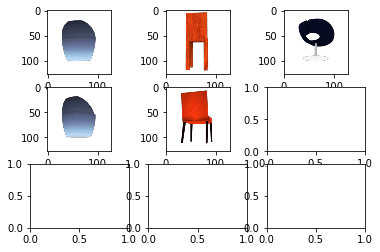

 Chamfer Cluster 4, Group 504.0: [3.18541356 3.72049407], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]


In [96]:
def chamfer_kmeans(kmeans, images_, chamfers_,groups_, n_cl,prepend='',n_displ=5):
    labels = kmeans.labels_
    for i in range(n_cl):
        mask = labels==i
        chamfers = chamfers_[mask]
        images = images_[mask]
        groups = groups_[mask]
        displ_str = prepend+'Chamfer Cluster {}: {}'.format(i,np.mean(chamfers,0)*100)
        print(images.shape)
        display_nn_images(images,n_displ, displ_str)
        uni_groups = np.unique(groups)
        for g in uni_groups:
            mask2 = groups==g
            images_g = images[mask2]
            chamfers_g = chamfers[mask2]
            yaw_r, pitch_r, roll_r = get_yaw_pitch_roll_range(g,divs)
            displ_str = prepend+' Chamfer Cluster {}, Group {}: {}, Yaw: {}, Pitch: {}'.format(i,g,np.mean(chamfers_g,0)*100,yaw_r, pitch_r)
            display_nn_images(images_g,n_displ-2, displ_str)


chamfer_kmeans(kmeans_all, all_images, chamfer_all,groups,n_clusters)
    